Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

**Source of the notebook - reusing As-Is (minor changes):** [Azure ML Notebooks](https://github.com/Azure/MachineLearningNotebooks)

# Train and deploy a model
_**Create and deploy a model directly from a notebook**_

---
---

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
    1. Viewing run results
    1. Simple parameter sweep
    1. Viewing experiment results
    1. Select the best model
1. [Deploy](#Deploy)
    1. Register the model
    1. Create a scoring file
    1. Describe your environment
    1. Descrice your target compute
    1. Deploy your webservice
    1. Test your webservice
    1. Clean up
1. [Next Steps](#Next%20Steps)

---

## Introduction
Azure Machine Learning provides capabilities to control all aspects of model training and deployment directly from a notebook using the AML Python SDK.  In this notebook we will
* connect to our AML Workspace
* create an experiment that contains multiple runs with tracked metrics
* choose the best model created across all runs
* deploy that model as a service

In the end we will have a model deployed as a web service which we can call from an HTTP endpoint

---

## Setup

In [2]:
import azureml.core
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("This notebook was created using version 1.0.2 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")


ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


This notebook was created using version 1.0.2 of the Azure ML SDK
You are currently using version 1.0.17 of the Azure ML SDK

Found the config file in: /home/nbuser/library/config.json
Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code F8V6LHGDP to authenticate.
Interactive authentication successfully completed.
Workspace name: AML_test
Azure region: eastus
Subscription id: 60dcdfe6-7fbc-4c33-96f9-ef1e832d16a3
Resource group: AML_test_rg


---

## Data
We will use the diabetes dataset for this experiement, a well-known small dataset that comes with scikit-learn.  This cell loads the dataset and splits it into random training and testing sets.


In [3]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")

Data contains 353 training samples and 89 test samples


---
## Train

Let's use scikit-learn to train a simple Ridge regression model.  We use AML to record interesting information about the model in an Experiment.  An Experiment contains a series of trials called Runs.  During this trial we use AML in the following way:
* We access an experiment from our AML workspace by name, which will be created if it doesn't exist
* We use `start_logging` to create a new run in this experiment
* We use `run.log()` to record a parameter, alpha, and an accuracy measure - the Mean Squared Error (MSE) to the run.  We will be able to review and compare these measures in the Azure Portal at a later time.
* We store the resulting model in the **outputs** directory, which is automatically captured by AML when the run is complete.
* We use `run.complete()` to indicate that the run is over and results can be captured and finalized

In [4]:
# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace=ws, name="train-within-notebook")

# Create a run object in the experiment
run = experiment.start_logging()
# Log the algorithm parameter alpha to the run
run.log('alpha', 0.03)

# Create, fit, and test the scikit-learn Ridge regression model
regression_model = Ridge(alpha=0.03)
regression_model.fit(data['train']['X'], data['train']['y'])
preds = regression_model.predict(data['test']['X'])

# Output the Mean Squared Error to the notebook and to the run
print('Mean Squared Error is', mean_squared_error(data['test']['y'], preds))
run.log('mse', mean_squared_error(data['test']['y'], preds))

# Save the model to the outputs directory for capture
joblib.dump(value=regression_model, filename='outputs/model.pkl')

# Complete the run
run.complete()

Mean Squared Error is 3424.900315896017


### Viewing run results
Azure Machine Learning stores all the details about the run in the Azure cloud.  Let's access those details by retrieving a link to the run using the default run output.  Clicking on the resulting link will take you to an interactive page presenting all run information.

In [5]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-within-notebook,f2f9ac8b-227c-4e8e-b563-1f087065924a,,Completed,Link to Azure Portal,Link to Documentation


### Simple parameter sweep
Now let's take the same concept from above and modify the **alpha** parameter.  For each value of alpha we will create a run that will store metrics and the resulting model.  In the end we can use the captured run history to determine which model was the best for us to deploy. 

Note that by using `with experiment.start_logging() as run` AML will automatically call `run.complete()` at the end of each loop.

This example also uses the **tqdm** library to provide a thermometer feedback

In [6]:
import numpy as np
from tqdm import tqdm

model_name = "model.pkl"

# list of numbers from 0 to 1.0 with a 0.05 interval
alphas = np.arange(0.0, 1.0, 0.05)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of runs, each train a model with a different alpha value
    with experiment.start_logging() as run:
        # Use Ridge algorithm to build a regression model
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X=data["train"]["X"], y=data["train"]["y"])
        preds = regression_model.predict(X=data["test"]["X"])
        mse = mean_squared_error(y_true=data["test"]["y"], y_pred=preds)

        # log alpha, mean_squared_error and feature names in run history
        run.log(name="alpha", value=alpha)
        run.log(name="mse", value=mse)

        # Save the model to the outputs directory for capture
        joblib.dump(value=regression_model, filename='outputs/model.pkl')


100%|██████████| 20/20 [05:04<00:00, 13.63s/it]


### Viewing experiment results
Similar to viewing the run, we can also view the entire experiment.  The experiment report view in the Azure portal lets us view all the runs in a table, and also allows us to customize charts.  This way, we can see how the alpha parameter impacts the quality of the model

In [7]:
# now let's take a look at the experiment in Azure portal.
experiment

Name,Workspace,Report Page,Docs Page
train-within-notebook,AML_test,Link to Azure Portal,Link to Documentation


### Select the best model 
Now that we've created many runs with different parameters, we need to determine which model is the best for deployment.  For this, we will iterate over the set of runs.  From each run we will take the *run id* using the `id` property, and examine the metrics by calling `run.get_metrics()`.  

Since each run may be different, we do need to check if the run has the metric that we are looking for, in this case, **mse**.  To find the best run, we create a dictionary mapping the run id's to the metrics.

Finally, we use the `tag` method to mark the best run to make it easier to find later. 

In [8]:
runs = {}
run_metrics = {}

# Create dictionaries containing the runs and the metrics for all runs containing the 'mse' metric
for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'mse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

# Find the run with the best (lowest) mean squared error and display the id and metrics
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['mse'])
best_run = runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', run_metrics[best_run_id])

# Tag the best run for identification later
best_run.tag("Best Run")

21it [00:05,  4.12it/s]


Best run is: a11ef08d-a22f-4001-94e6-5caef0bdca9e
Metrics: {'alpha': 0.4, 'mse': 3295.741064355809}


---
## Deploy
Now that we have trained a set of models and identified the run containing the best model, we want to deploy the model for real time inferencing.  The process of deploying a model involves
* registering a model in your workspace
* creating a scoring file containing init and run methods
* creating an environment dependency file describing packages necessary for your scoring file
* creating a docker image containing a properly described environment, your model, and your scoring file
* deploying that docker image as a web service

### Register a model
We have already identified which run contains the "best model" by our evaluation criteria.  Each run has a file structure associated with it that contains various files collected during the run.  Since a run can have many outputs we need to tell AML which file from those outputs represents the model that we want to use for our deployment.  We can use the `run.get_file_names()` method to list the files associated with the run, and then use the `run.register_model()` method to place the model in the workspace's model registry.

When using `run.register_model()` we supply a `model_name` that is meaningful for our scenario and the `model_path` of the model relative to the run.  In this case, the model path is what is returned from `run.get_file_names()`

In [9]:
# View the files in the run
for f in best_run.get_file_names():
    print(f)
    
# Register the model with the workspace
model = best_run.register_model(model_name='best_model', model_path='outputs/model.pkl')

outputs/model.pkl


Once a model is registered, it is accessible from the list of models on the AML workspace.  If you register models with the same name multiple times, AML keeps a version history of those models for you.  The `Model.list()` lists all models in a workspace, and can be filtered by name, tags, or model properties.   

In [10]:
# Find all models called "best_model" and display their version numbers
from azureml.core.model import Model
models = Model.list(ws, name='best_model')
for m in models:
    print(m.name, m.version)

best_model 1


### Create a scoring file

Since your model file can essentially be anything you want it to be, you need to supply a scoring script that can load your model and then apply the model to new data.  This script is your 'scoring file'.  This scoring file is a python program containing, at a minimum, two methods `init()` and `run()`.  The `init()` method is called once when your deployment is started so you can load your model and any other required objects.  This method uses the `get_model_path` function to locate the registered model inside the docker container.  The `run()` method is called interactively when the web service is called with one or more data samples to predict.

The scoring file used for this exercise is [here](score.py).  


### Describe your environment

Each modelling process may require a unique set of packages.  Therefore we need to create a dependency file providing instructions to AML on how to contstruct a docker image that can support the models and any other objects required for inferencing.  In the following cell, we create a environment dependency file, *myenv.yml* that specifies which libraries are needed by the scoring script.  You can create this file manually, or use the `CondaDependencies` class to create it for you.

Next we use this environment file to describe the docker container that we need to create in order to deploy our model.  This container is created using our environment description and includes our scoring script.

In [11]:
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core.image import ContainerImage

# Create an empty conda environment and add the scikit-learn package
env = CondaDependencies()
env.add_conda_package("scikit-learn")

# Display the environment
print(env.serialize_to_string())

# Write the environment to disk
with open("myenv.yml","w") as f:
    f.write(env.serialize_to_string())

# Create a configuration object indicating how our deployment container needs to be created
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                    runtime="python", 
                                    conda_file="myenv.yml")

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



### Describe your target compute
In addition to the container, we also need to describe the type of compute we want to allocate for our webservice.  In in this example we are using an [Azure Container Instance](https://azure.microsoft.com/en-us/services/container-instances/) which is a good choice for quick and cost-effective dev/test deployment scenarios.  ACI instances require the number of cores you want to run and memory you need.  Tags and descriptions are available for you to identify the instances in AML when viewing the Compute tab in the AML Portal.

For production workloads, it is better to use [Azure Kubernentes Service (AKS)](https://azure.microsoft.com/en-us/services/kubernetes-service/) instead. Try [this notebook](11.production-deploy-to-aks.ipynb) to see how that can be done from Azure ML.


In [12]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'sample name': 'AML 101'}, 
                                               description='This is a great example.')

### Deploy your webservice
The final step to deploying your webservice is to call `WebService.deploy_from_model()`.  This function uses the deployment and image configurations created above to perform the following:
* Build a docker image
* Deploy to the docker image to an Azure Container Instance
* Copy your model files to the Azure Container Instance
* Call the `init()` function in your scoring file
* Provide an HTTP endpoint for scoring calls

The `deploy_from_model` method requires the following parameters
* `workspace` - the workspace containing the service
* `name` - a unique named used to identify the service in the workspace
* `models` - an array of models to be deployed into the container
* `image_config` - a configuration object describing the image environment
* `deployment_config` - a configuration object describing the compute type
 
**Note:** The web service creation can take several minutes.  

In [13]:
%%time
from azureml.core.webservice import Webservice

# Create the webservice using all of the precreated configurations and our best model
service = Webservice.deploy_from_model(name='my-aci-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config,
                                       workspace=ws)

# Wait for the service deployment to complete while displaying log output
service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image my-aci-svc:1, operation "Succeeded"
Creating service
Running...................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 4.32 s, sys: 1.65 s, total: 5.98 s
Wall time: 5min 50s



### Test your webservice

Now that your web service is runing you can send JSON data directly to the service using the `run` method.  This cell pulls the first test sample from the original dataset into JSON and then sends it to the service.

In [14]:
import json
# scrape the first row from the test set.
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

#score on our service
service.run(input_data = test_samples)

[217.67978776218712]

This cell shows how you can send multiple rows to the webservice at once.  It then calculates the residuals - that is, the errors - by subtracting out the actual values from the results.  These residuals are used later to show a plotted result.

In [15]:
# score the entire test set.
test_samples = json.dumps({'data': X_test.tolist()})

result = service.run(input_data = test_samples)
residual = result - y_test

This cell shows how you can use the `service.scoring_uri` property to access the HTTP endpoint of the service and call it using standard POST operations.

In [16]:
import requests

# use the first row from the test set again
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

# create the required header
headers = {'Content-Type':'application/json'}

# post the request to the service and display the result
resp = requests.post(service.scoring_uri, test_samples, headers = headers)
print(resp.text)

[217.67978776218712]


### Residual graph
One way to understand the behavior of your model is to see how the data performs against data with known results.  This cell uses matplotlib to create a histogram of the residual values, or errors, created from scoring the test samples.

A good model should have residual values that cluster around 0 - that is, no error.  Observing the resulting histogram can also show you if the model is skewed in any particular direction.

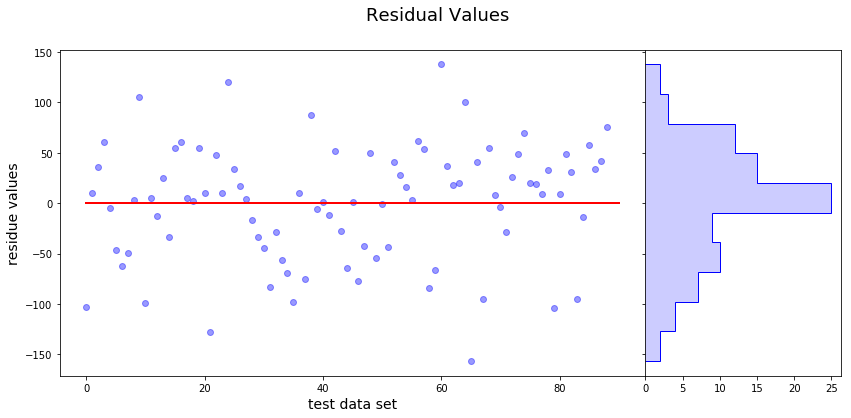

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Residual Values', fontsize = 18)

f.set_figheight(6)
f.set_figwidth(14)

a0.plot(residual, 'bo', alpha=0.4)
a0.plot([0,90], [0,0], 'r', lw=2)
a0.set_ylabel('residue values', fontsize=14)
a0.set_xlabel('test data set', fontsize=14)

a1.hist(residual, orientation='horizontal', color='blue', bins=10, histtype='step')
a1.hist(residual, orientation='horizontal', color='blue', alpha=0.2, bins=10)
a1.set_yticklabels([])

plt.show()

### Clean up

Delete the ACI instance to stop the compute and any associated billing.

In [ ]:
%%time
service.delete()

---
## Next Steps